# Sistemas de Recomemdação

## Importar pacotes e bases

### 1. Imports e Configuração Geral

In [46]:
# ===============================================
# SISTEMA DE RECOMENDAÇÃO HÍBRIDO — TCC
# ===============================================

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import correlation, jaccard
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

### 2. Carregamento

In [47]:
# Leitura dos dados pré-tratados
ratings_original = pd.read_csv("bases/user_ratings.csv")
# Carregar todas as colunas para permitir uso de cat*
games = pd.read_csv("bases/games.csv")
mechanics = pd.read_csv("bases/mechanics.csv")

### 3. Limpeza, tratamentos e filtragem

In [48]:
# Consolidar duplicatas: média das notas por usuário e jogo
ratings_original = ratings_original.groupby(['Username', 'BGGId'], as_index=False)['Rating'].mean()


In [49]:
# --- Filtrar jogos modernos ---
games = games[games['YearPublished'] >= 1990]
ratings_original = ratings_original[ratings_original['BGGId'].isin(games['BGGId'])]

# Consolidar duplicatas: média das notas por usuário e jogo
# ratings = ratings.groupby(['Username', 'BGGId'], as_index=False)['Rating'].mean()

# --- Amostra leve ---
sample_users = ratings_original['Username'].value_counts().head(5000).index
sample_games = ratings_original['BGGId'].value_counts().head(2000).index
ratings = ratings_original[ratings_original['Username'].isin(sample_users) & ratings_original['BGGId'].isin(sample_games)]


print(f"Dimensões finais da base: {ratings.shape}")
print(f"Usuários únicos: {ratings['Username'].nunique()}")
print(f"Jogos únicos: {ratings['BGGId'].nunique()}")

Dimensões finais da base: (2217792, 3)
Usuários únicos: 5000
Jogos únicos: 2000


### 4. Divisão Treino/Teste por Usuário

A função `split_user` realiza a divisão dos dados mantendo **separação por usuário**, evitando que dados do mesmo usuário apareçam tanto no treino quanto no teste.

**Filtro de mínimo de 5 avaliações:**
- Usuários com **≤ 5 avaliações** são excluídos do conjunto de teste
- Motivo: ao dividir 20% dos dados, usuários com poucas avaliações (ex: 2-3) resultariam em 0-1 avaliação no teste, insuficiente para avaliação
- Usuários com **> 5 avaliações** garantem pelo menos 1 avaliação no teste e histórico suficiente no treino

Esta abordagem é adequada para sistemas de recomendação, onde é essencial que o modelo aprenda padrões de cada usuário antes de predizer suas avaliações.

In [50]:
# --- Divisão treino/teste por usuário ---
def split_user(df, test_size=0.2):
    test_rows = []
    for user, group in df.groupby('Username'):
        if len(group) > 5:
            test = group.sample(frac=test_size, random_state=42)
            test_rows.append(test)
    test_df = pd.concat(test_rows)
    train_df = df.drop(test_df.index)
    return train_df, test_df

train_df, test_df = split_user(ratings)


## Filtragem Colaborativa: User-User

### 1. Matriz Usuário-Item

In [51]:
# --- Criar matriz usuário-item ---
R_train = train_df.pivot(index='Username', columns='BGGId', values='Rating')
R_test = test_df.pivot(index='Username', columns='BGGId', values='Rating')
R_test = R_test.reindex_like(R_train)

### 2. Similaridade Pearson


In [52]:
# 1. Pearson (sim_cf_pearson)
# O método .corr() do pandas nas linhas (que são os usuários) calcula a correlação entre usuários,
# considerando apenas os itens co-avaliados.
sim_cf_pearson = R_train.T.corr(method='pearson')
sim_cf_pearson = pd.DataFrame(sim_cf_pearson, index=R_train.index, columns=R_train.index)
print("1. CF (Pearson User-User) Similaridade Calculada.")

1. CF (Pearson User-User) Similaridade Calculada.


### 3. Calcular a média de cada usuário na matriz de treino

In [53]:
user_means = R_train.mean(axis=1)

# A matriz de similaridade (sim_matrix) será uma das três: sim_cf_pearson, sim_cf_cosine, ou sim_cf_euclidean

### 4. Previsão das notas FC user-user

Encontrar os $K=30$ usuráios próximos 

In [54]:
def predict_cf_user_user(user_id, item_id, R_train, sim_matrix, user_means, k=30):
    """
    Prevê a nota de um usuário para um item usando CF User-User.

    Args:
        user_id (str): O ID do usuário para o qual a previsão será feita.
        item_id (int): O ID do item que será previsto.
        R_train (DataFrame): Matriz de avaliações de treino (Usuário x Item).
        sim_matrix (DataFrame): Matriz de similaridade User-User.
        user_means (Series): Média de notas por usuário.
        k (int): Número de vizinhos a considerar.
    
    Returns:
        float: A nota prevista.
    """
    
    # 1. Se o usuário ou item não estiverem na matriz de treino, prever a média do usuário.
    if user_id not in user_means.index or item_id not in R_train.columns:
        return user_means.get(user_id, 0.0)
    
    # Média do usuário u
    mean_u = user_means[user_id]
    
    # 2. Encontrar todos os usuários (vizinhos) que avaliaram o item 'item_id'
    rated_by_v = R_train[item_id].dropna().index
    
    # 3. Filtrar a similaridade de u para os vizinhos v que avaliaram o item i
    # Exclui o próprio usuário 'u'
    sim_u_v = sim_matrix.loc[user_id, rated_by_v].drop(user_id, errors='ignore')
    
    # 4. Obter as notas e médias dos vizinhos
    ratings_v_i = R_train.loc[sim_u_v.index, item_id]
    means_v = user_means.loc[sim_u_v.index]
    
    # 5. Calcular a diferença da nota real para a média do vizinho: (r_v,i - mean_v)
    deviation_v = ratings_v_i - means_v
    
    # 6. Combinar similaridade, desvio e selecionar os k melhores vizinhos
    # Cria uma Série com o produto (similaridade * desvio)
    weighted_deviations = sim_u_v * deviation_v
    
    # Selecionar os K melhores vizinhos (maior valor absoluto da similaridade)
    # A prioridade é vizinhos com similaridade alta, mesmo que negativa.
    top_k_neighbors = weighted_deviations.abs().nlargest(k).index
    
    # Filtrar pelo top K
    weighted_deviations_k = weighted_deviations.loc[top_k_neighbors]
    sim_u_v_k = sim_u_v.loc[top_k_neighbors]
    
    # 7. Previsão: Verifica se há vizinhos válidos
    if sim_u_v_k.empty or sim_u_v_k.abs().sum() == 0:
        return mean_u
    
    # Soma ponderada
    numerator = weighted_deviations_k.sum()
    denominator = sim_u_v_k.abs().sum()
    
    # Previsão final
    prediction = mean_u + (numerator / denominator)
    
    # Opcional: Limitar a previsão ao range de notas (ex: 1 a 10)
    # prediction = np.clip(prediction, 1.0, 10.0) 
    
    return prediction

### 5. Teste para um user qualquer ($k=1000$)

In [55]:
# Teste com uma das matrizes de similaridade, por exemplo Pearson:
sim_matrix = sim_cf_pearson 
# Exemplo de usuário e item do conjunto de teste (substitua pelos seus dados)
user_test = test_df['Username'].iloc[445] 
item_test = test_df['BGGId'].iloc[445]
 
pred = predict_cf_user_user(user_test, item_test, R_train, sim_matrix, user_means, k=1000)
print(f"Previsão de nota para {user_test} no item {item_test}: {pred:.2f}")
print(f"Previsão de nota para {user_test} no item {item_test}: {pred:.2f}")
print(f"Real avaliação de nota de {user_test} no item {item_test}: {test_df['Rating'].iloc[445]:.2f}")

Previsão de nota para 1Aspielerin no item 4218: 5.92
Previsão de nota para 1Aspielerin no item 4218: 5.92
Real avaliação de nota de 1Aspielerin no item 4218: 7.00


### 6. Métricas de avaliação

#### 6.1 Acuárica (RMSE e MAE)

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_accuracy_metrics(y_true, y_pred):
    """Calcula RMSE e MAE."""
    # Remove pares onde não foi possível fazer a previsão (se houver NaNs nas previsões)
    valid_indices = ~np.isnan(y_pred)
    y_true_valid = y_true[valid_indices]
    y_pred_valid = y_pred[valid_indices]
    
    if len(y_true_valid) == 0:
        return np.nan, np.nan
        
    rmse = np.sqrt(mean_squared_error(y_true_valid, y_pred_valid))
    mae = mean_absolute_error(y_true_valid, y_pred_valid)
    return rmse, mae



#### 6.2 Métricas de Rankeamento: Precisão@K, Recall@K

In [57]:
def calculate_ranking_metrics(R_train, R_test, predictions_df, relevance_threshold=7.0, N=10):
    """Calcula Precision@N e Recall@N."""
    
    all_precision = []
    all_recall = []
    
    # Itera sobre cada usuário no conjunto de teste
    for user in R_test.index:
        # Pega as avaliações reais e previstas do usuário no conjunto de teste
        true_ratings = R_test.loc[user].dropna()
        if true_ratings.empty:
            continue
            
        # 1. Itens realmente relevantes (True Positives + False Negatives)
        relevant_items = true_ratings[true_ratings >= relevance_threshold].index
        
        # 2. Previsões para todos os itens não avaliados no treino
        # Encontra itens que o usuário não avaliou no treino, mas que existem na base
        unrated_items = R_train.columns.difference(R_train.loc[user].dropna().index)
        
        # Usa as previsões que você gerou, mas também precisamos prever para itens
        # que o usuário *não* avaliou no treino (mas que avaliou no teste)
        
        # Para simplificar, vamos usar as previsões geradas APENAS para os itens do TESTE.
        # Em um cenário real, você faria previsões para todos os itens não avaliados.
        
        # Pega as previsões para os itens que o usuário avaliou no teste
        user_predictions = predictions_df.loc[user, true_ratings.index].dropna()
        
        if user_predictions.empty:
            continue
            
        # 3. Ranqueia e seleciona o Top N
        top_n_recommended = user_predictions.sort_values(ascending=False).head(N).index
        
        # 4. Cálculo da Métrica
        # Intersecção: itens recomendados que são relevantes (True Positives)
        hits = len(top_n_recommended.intersection(relevant_items))
        
        # Precision@N: TP / (TP + FP) = Hits / N
        precision = hits / N
        all_precision.append(precision)
        
        # Recall@N: TP / (TP + FN) = Hits / Total de relevantes
        if len(relevant_items) > 0:
            recall = hits / len(relevant_items)
            all_recall.append(recall)
        
    avg_precision = np.mean(all_precision)
    avg_recall = np.mean(all_recall)
    return avg_precision, avg_recall

### 7. colocando o o FC para funcionar

In [ ]:
print("Iniciando o cálculo de previsões e métricas...\n\n")

# 1. Gerar Previsões para a base de teste
predictions = {}


# Itera sobre cada par (Usuário, Item) no test_df
for index, row in test_df.iterrows():
    user = row['Username']
    item = row['BGGId']
        
    # Usamos a função de previsão
    pred_rating = predict_cf_user_user(user, item, R_train, sim_matrix, user_means, k=30)
    predictions[(user, item)] = pred_rating

# 2. Converte as previsões para DataFrame para facilitar o alinhamento
pred_series = pd.Series(predictions, index=pd.MultiIndex.from_tuples(predictions.keys(), names=['Username', 'BGGId']))
    
# 3. Alinha as previsões e notas reais para cálculo das métricas
y_true = test_df['Rating'].values
y_pred_fc = pred_series.reindex(test_df.set_index(['Username', 'BGGId']).index).values
    
# 4. Calcular Métricas de Precisão
rmse_fc, mae_fc = calculate_accuracy_metrics(y_true, y_pred_fc)

#print(f"CF User-User -> RMSE: {rmse_fc:.4f}")
#print(f"CF User-User -> MAE:  {mae_fc:.4f}")

    
# 5. Calcular Métricas de Ranking (Requer previsões em um formato específico)
    
# Reestrutura as previsões em uma matriz User x Item alinhada ao R_test
predictions_fc_df = pred_series.unstack()
    
# Usando N=10 e Threshold=7.0
precision, recall = calculate_ranking_metrics(R_train, R_test, predictions_fc_df, relevance_threshold=7.0, N=10)

# 6. Armazenar Resultados
results_fc = {
        'RMSE': rmse_fc,
        'MAE': mae_fc,
        'Precision@10': precision,
        'Recall@10': recall
    }

print("\n--- Resultados Finais CF User-User ---")
for k, v in results_fc.items():
    print(f"{k}: {v:.4f}")

Iniciando o cálculo de previsões e métricas...
CF User-User -> RMSE: 1.7101
CF User-User -> MAE:  1.4000

--- Resultados Finais CF User-User ---
RMSE: 1.7101
MAE: 1.4000
Precision@10: 0.8601
Recall@10: 0.1755


## Método Baseline

### 0. Explicações



O método **Baseline** (ou Média Ajustada) é uma abordagem fundamental e um ponto de partida em sistemas de recomendação. Ele é um modelo preditivo que tenta explicar a variação das avaliações dos usuários com base em **três componentes principais de viés**.

A principal característica do modelo Baseline é sua **simplicidade** e **interpretabilidade**, pois ele não depende da similaridade entre usuários ou itens, mas sim de tendências médias.

#### 📝 Fórmula e Componentes

A previsão da nota ($\hat{r}_{u,i}$) que o usuário $u$ daria ao item $i$ é dada pela soma de três fatores de viés:

$$\hat{r}_{u,i} = \mu + b_u + b_i$$

Onde:

##### 1. Média Global ($\mu$)

* **Definição:** A média de **todas** as avaliações presentes no conjunto de treino.
* **Interpretação:** É o valor médio esperado para qualquer avaliação, sem saber nada sobre o usuário ou o item.

##### 2. Viés do Usuário ($b_u$)

* **Definição:** O desvio médio do usuário $u$ em relação à média global $\mu$.
* **Cálculo:** $b_u = (\text{Média das notas de } u) - \mu$
* **Interpretação:**
    * Se $b_u > 0$, o usuário $u$ tende a dar notas **mais altas** que a média geral (um avaliador "bonzinho").
    * Se $b_u < 0$, o usuário $u$ tende a dar notas **mais baixas** que a média geral (um avaliador "rigoroso").

##### 3. Viés do Item ($b_i$)

* **Definição:** O desvio médio do item $i$ em relação à média global $\mu$.
* **Cálculo:** $b_i = (\text{Média das notas de } i) - \mu$
* **Interpretação:**
    * Se $b_i > 0$, o item $i$ tende a receber notas **mais altas** que a média (um item popular/bom).
    * Se $b_i < 0$, o item $i$ tende a receber notas **mais baixas** que a média (um item impopular/ruim).

#### 💡 Funcionamento e Aplicação

O modelo funciona somando esses vieses à média global. Por exemplo:

> Se a Média Global ($\mu$) é **7.5**, e o usuário $u$ tende a dar notas 0.5 ponto **acima** da média ($b_u = +0.5$), e o item $i$ é 0.2 ponto **abaixo** da média ($b_i = -0.2$), a previsão será:
>
> $$\hat{r}_{u,i} = 7.5 + 0.5 + (-0.2) = 7.8$$

#### Vantagens do Método Baseline

* **Simplicidade e Rapidez:** Extremamente rápido de treinar e de fazer previsões.
* **Referência:** Serve como um **piso de desempenho (benchmark)**. Qualquer modelo mais complexo (como CF ou Fatoração de Matriz) deve superar o Baseline para ser considerado útil.
* **Base para Fatoração de Matriz:** Muitos modelos avançados, como SVD e FunkSVD, utilizam o modelo Baseline como a primeira camada de suas previsões, adicionando fatores latentes (componentes não-viesados) sobre a fórmula $\mu + b_u + b_i$.

### 1. Média Global, Viés de Usuário e Viés de Item

In [61]:
#R_train_na = R_train.fillna(0)

# 1. Média Global (mu)
mu = np.nanmean(R_train.values)

# 2. Viés do Item (bi)
#bi = train_df.groupby('BGGId')['Rating'].mean() - mu
bi = R_train.apply(lambda col: np.nanmean(col - mu), axis=0)

# 3. Viés do Usuário (bu)
#bu = train_df.groupby('Username')['Rating'].mean() - mu #- bi
bu = R_train.apply(lambda row: np.nanmean(row - mu - bi), axis=1)


print(f"Média Global (mu): {mu:.4f}")
#print(f"\nVieses (bi) calculados para {len(bi)} itens: \n{bi.head()}.")
#print(f"\nVieses (bu) calculados para {len(bu)} usuários: \n{bu.head()}.")


Média Global (mu): 6.9319


### 2. Exemplo de aplicação

In [62]:
import pandas as pd
import numpy as np

# --- Comparação de 5 Exemplos (Modelo Baseline vs. Nota Real) ---
print("--- Comparação de 5 Exemplos (Modelo Baseline vs. Nota Real) ---")
print("------------------------------------------------------------------")

# 1. Selecionar 5 usuários únicos e aleatórios do conjunto de teste
try:
    unique_users = test_df['Username'].unique()
    
    if len(unique_users) < 5:
        # Se houver menos de 5 usuários únicos, usamos todos
        users_to_sample = unique_users
        print(f"Atenção: A base de teste tem apenas {len(unique_users)} usuários únicos. Exibindo todos.")
    else:
        # Escolhe 5 usuários aleatórios únicos (replace=False)
        users_to_sample = np.random.choice(unique_users, size=5, replace=False)

except Exception as e:
    # Este erro não deve ocorrer se 'test_df' estiver definido
    print(f"Erro ao selecionar usuários únicos (Variáveis não definidas?): {e}")
    users_to_sample = []

i = 0
# 2. Iterar sobre os 5 usuários selecionados e pegar 1 item de teste para cada
for user_id in users_to_sample:
    # Pega o primeiro item avaliado por este usuário no conjunto de teste
    # Usamos .iloc[0] para pegar o primeiro item deste usuário no test_df
    user_test_data = test_df[test_df['Username'] == user_id].iloc[0]
    
    item_id = user_test_data['BGGId']
    real_rating = user_test_data['Rating']

    try:
        # 3. Acessar os Vieses
        # Usamos .get() com 0.0 como fallback (embora os usuários e itens amostrados
        # estejam na base de treino e, portanto, em bu/bi)
        bu_val = bu.get(user_id, 0.0)
        bi_val = bi.get(item_id, 0.0)
        
        # 4. Previsão do Modelo Baseline
        pred_baseline = mu + bu_val + bi_val
        pred_baseline = np.clip(pred_baseline, 1.0, 10.0) # Limite de 1 a 10

        # 5. Cálculo do Erro
        erro_absoluto = abs(real_rating - pred_baseline)

        # 6. Apresentação dos resultados
        print(f"\n[Exemplo {i + 1}] User: {user_id}, Item: {item_id}")
        print(f"  > Viés User (bu): {bu_val:+.2f} | Viés Item (bi): {bi_val:+.2f} | Média Global (mu): {mu:.2f}")
        print(f"  > PREVISÃO BASELINE: {pred_baseline:.4f}")
        print(f"  > AVALIAÇÃO REAL:    {real_rating:.4f}")
        print(f"  > ERRO ABSOLUTO:     {erro_absoluto:.4f}")
        
    except Exception as e:
        print(f"\nErro ao processar o usuário {user_id}: {e}")
    
    i += 1

print("\n------------------------------------------------------------------")

--- Comparação de 5 Exemplos (Modelo Baseline vs. Nota Real) ---
------------------------------------------------------------------

[Exemplo 1] User: roo414, Item: 29934
  > Viés User (bu): -0.08 | Viés Item (bi): -0.18 | Média Global (mu): 6.93
  > PREVISÃO BASELINE: 6.6711
  > AVALIAÇÃO REAL:    6.0000
  > ERRO ABSOLUTO:     0.6711

[Exemplo 2] User: bluekingzog, Item: 251678
  > Viés User (bu): +0.66 | Viés Item (bi): -0.02 | Média Global (mu): 6.93
  > PREVISÃO BASELINE: 7.5753
  > AVALIAÇÃO REAL:    7.9000
  > ERRO ABSOLUTO:     0.3247

[Exemplo 3] User: dbucak, Item: 116954
  > Viés User (bu): +0.96 | Viés Item (bi): -0.36 | Média Global (mu): 6.93
  > PREVISÃO BASELINE: 7.5353
  > AVALIAÇÃO REAL:    8.0000
  > ERRO ABSOLUTO:     0.4647

[Exemplo 4] User: Delthos, Item: 143519
  > Viés User (bu): +0.15 | Viés Item (bi): -0.28 | Média Global (mu): 6.93
  > PREVISÃO BASELINE: 6.8086
  > AVALIAÇÃO REAL:    7.0000
  > ERRO ABSOLUTO:     0.1914

[Exemplo 5] User: moriarty 101, Item: 

### 3. Previsão do Baseline

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Função de previsão usando o modelo baseline
def predict_baseline(user_id, item_id, mu, bu, bi):
    bu_i = bu.get(user_id, 0.0)
    bi_i = bi.get(item_id, 0.0)
    pred = mu + bu_i + bi_i
    return float(np.clip(pred, 1.0, 10.0))

# Prever todas as notas de teste
preds = {
    (u, i): predict_baseline(u, i, mu, bu, bi)
    for u, i in zip(test_df['Username'], test_df['BGGId'])
}
pred_series = pd.Series(preds, index=pd.MultiIndex.from_tuples(preds.keys(), names=['Username', 'BGGId']))
pred_bl_df = pred_series.unstack()

# Calcular métricas de erro
y_true = test_df['Rating'].values
y_pred_bl = pred_series.reindex(test_df.set_index(['Username', 'BGGId']).index).values


### 4. Métricas de Avaliação do Modelo Baseline

#### 4.1 Métricas de Acurácia: RMSE e MAE

In [64]:
rmse_bl = np.sqrt(mean_squared_error(y_true, y_pred_bl))
mae_bl = mean_absolute_error(y_true, y_pred_bl)
print(f"Baseline - RMSE: {rmse_bl:.4f}, MAE: {mae_bl:.4f}")

Baseline - RMSE: 1.1141, MAE: 0.8352


#### 4.2 Métricas de Rankeamento: Precisão e Recall

In [65]:
# 7. Calcular precisão@N e recall@N
R_test_matrix = test_df.pivot(index='Username', columns='BGGId', values='Rating').reindex_like(pred_bl_df)
precision, recall = calculate_ranking_metrics(R_train, R_test_matrix, pred_bl_df)

print(f"Baseline - Precision@10: {precision:.4f}, Recall@10: {recall:.4f}")

Baseline - Precision@10: 0.8488, Recall@10: 0.1721


## Baseada em Conteúdo (item_item)

### 1. Matriz de Similaridade Jaccard

In [66]:
from scipy.spatial.distance import jaccard

# --- Funções Auxiliares (Jaccard) ---

def calculate_jaccard_similarity_matrix(df):
    """Calcula a matriz de Similaridade de Jaccard (1 - Distância Jaccard) para um DataFrame Item x Feature."""
    data_array = df.values
    n = data_array.shape[0]
    sim_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(i, n):
            # Jaccard é a distância (1 - Sim)
            dist = jaccard(data_array[i], data_array[j])
            sim = 1 - dist
            sim_matrix[i, j] = sim
            sim_matrix[j, i] = sim
            
    return pd.DataFrame(sim_matrix, index=df.index, columns=df.index)

# Preparação e Filtro da Matriz de Conteúdo (Item x Feature, alinhada aos itens de R_train)
# Assumimos que 'mechanics' foi preparado anteriormente, mas refazemos o alinhamento
mechanics_prepared = mechanics.set_index('BGGId').reindex(R_train.columns).fillna(0)

# 1. Calcular a Similaridade BC usando Jaccard (Item-Item)
sim_bc_jaccard = calculate_jaccard_similarity_matrix(mechanics_prepared)

print("Similaridade Baseada em Conteúdo (Jaccard) Item-Item Calculada.")
print(f"Dimensões da matriz sim_bc_jaccard: {sim_bc_jaccard.shape}")

Similaridade Baseada em Conteúdo (Jaccard) Item-Item Calculada.
Dimensões da matriz sim_bc_jaccard: (2000, 2000)


### 2. Predição BC item_item usando Jaccard

In [67]:
def predict_bc_item_item(user_id, item_id, R_train, sim_matrix_item_item, k_items=30):
    """
    Prevê a nota de um usuário para um item usando BC Item-Item.

    Args:
        user_id (str): ID do usuário.
        item_id (int): ID do item que será previsto.
        R_train (DataFrame): Matriz de avaliações de treino (Usuário x Item).
        sim_matrix_item_item (DataFrame): Matriz de similaridade Item-Item.
        k_items (int): Número de itens vizinhos mais parecidos a considerar.
    """
    
    # Se o item não está na matriz de similaridade, a previsão é a média global
    if item_id not in sim_matrix_item_item.index:
        return np.nanmean(R_train.values)
        
    # 1. Obter itens avaliados pelo usuário u
    user_ratings = R_train.loc[user_id].dropna()
    rated_items = user_ratings.index
    
    # 2. Obter similaridade entre item-alvo (i) e todos os itens avaliados (j)
    # Excluímos o próprio item-alvo se ele estiver na lista de avaliados (o que não deve acontecer no treino)
    similarities_i_j = sim_matrix_item_item.loc[item_id, rated_items]
    
    # 3. Calcular o peso: similaridade * nota real
    weighted_ratings = similarities_i_j * user_ratings.loc[similarities_i_j.index]
    
    # 4. Selecionar os K melhores itens vizinhos (maior similaridade)
    top_k_items = similarities_i_j.abs().nlargest(k_items).index
    
    # Filtrar pelo top K
    weighted_ratings_k = weighted_ratings.loc[top_k_items]
    similarities_i_j_k = similarities_i_j.loc[top_k_items]
    
    # 5. Previsão
    denominator = similarities_i_j_k.abs().sum()
    
    if denominator == 0:
        # Se não houver similaridade para nenhum vizinho, retornar a média do usuário
        return R_train.loc[user_id].mean()
        
    numerator = weighted_ratings_k.sum()
    prediction = numerator / denominator
    
    # Limitar a previsão ao range de notas (1 a 10)
    return np.clip(prediction, 1.0, 10.0)

### 3. Colocando o Modelo BC Item-Item para funcionar com o conjunto de teste

Considerando $k=30$ vizinhos mais próximos

In [68]:
K_ITEMS = 30 # Número de itens vizinhos a considerar

print("\n--- Processando Modelo BC Item-Item (Jaccard) ---")

# 1. Gerar Previsões para a base de teste
predictions_bc = {}

# Itera sobre cada par (Usuário, Item) no test_df
for index, row in test_df.iterrows():
    user = row['Username']
    item = row['BGGId']
    
    # Usamos a função de previsão BC Item-Item
    pred_rating = predict_bc_item_item(
        user, item, R_train, sim_bc_jaccard, k_items=K_ITEMS
    )
    predictions_bc[(user, item)] = pred_rating

# Converte as previsões para DataFrame para facilitar o alinhamento
pred_series_bc = pd.Series(predictions_bc, 
                            index=pd.MultiIndex.from_tuples(predictions_bc.keys(), 
                                                            names=['Username', 'BGGId']))




--- Processando Modelo BC Item-Item (Jaccard) ---


### 4. Métricas de Avaliação BC

#### 4.1 Métricas de Acurácia (RMSE, MAE)

In [69]:
# 2. Alinhar e Calcular Métricas de Precisão (RMSE e MAE)
y_true = test_df['Rating'].values
y_pred_bc = pred_series_bc.reindex(test_df.set_index(['Username', 'BGGId']).index).values

rmse_bc = np.sqrt(mean_squared_error(y_true, y_pred_bc))
mae_bc = mean_absolute_error(y_true, y_pred_bc)



#### 4.2 Métricas de Ranking (Precision@N e Recall@N)

In [70]:
# 3. Calcular Métricas de Ranking (P@10 e R@10)
# Reestrutura as previsões em uma matriz User x Item alinhada ao R_test
predictions_df_bc = pred_series_bc.unstack()

# Usando N=10 e Threshold=7.0
precision_bc, recall_bc = calculate_ranking_metrics(R_train, R_test, predictions_df_bc, relevance_threshold=7.0, N=10)

# 4. Armazenar e Apresentar Resultados
results_bc = {
    'RMSE': rmse_bc,
    'MAE': mae_bc,
    'Precision@10': precision_bc,
    'Recall@10': recall_bc
}

print(f"\nResultado BC Jaccard: RMSE={rmse_bc:.4f}, MAE={mae_bc:.4f}, P@10={precision_bc:.4f}, R@10={recall_bc:.4f}")



Resultado BC Jaccard: RMSE=1.1865, MAE=0.8881, P@10=0.7925, R@10=0.1596


## Modelo Híbrido

### 1. Predição do Modelo Híbrido (Baseline + BC)

In [90]:
def hybrid_late_fusion(y_pred_bc, y_pred_bl, alpha):
    y_hybrid = alpha * y_pred_bc + (1 - alpha) * y_pred_bl
    
    # fallback automático: se BC for NaN, usa baseline
    mask = np.isnan(y_pred_bc)
    y_hybrid[mask] = y_pred_bl[mask]
    
    return np.clip(y_hybrid, 1.0, 10.0)


ALPHA = 0.2

y_pred_hybrid = hybrid_late_fusion(
    y_pred_bc=y_pred_bc,
    y_pred_bl=y_pred_bl,
    alpha=ALPHA
)



#### 2. Métricas de Avaliação

In [91]:
rmse_hybrid, mae_hybrid = calculate_accuracy_metrics(y_true, y_pred_hybrid)

# 3. Calcular Métricas de Ranking (P@10 e R@10)
pred_series_hybrid = pd.Series(
    y_pred_hybrid,
    index=test_df.set_index(['Username', 'BGGId']).index
)


predictions_df_hybrid = pred_series_hybrid.unstack()
precision_hybrid, recall_hybrid = calculate_ranking_metrics(R_train, R_test, predictions_df_hybrid, relevance_threshold=7.0, N=10)

# 4. Apresentar Resultados
print(f"\nResultado Híbrido (alpha={ALPHA}):")
print(f"  RMSE={rmse_hybrid:.4f}, MAE={mae_hybrid:.4f}, P@10={precision_hybrid:.4f}, R@10={recall_hybrid:.4f}")


Resultado Híbrido (alpha=0.2):
  RMSE=1.1072, MAE=0.8274, P@10=0.8581, R@10=0.1745


### 3. Considerações

O modelo **Híbrido Ponderado (BC Jaccard + Baseline)** não só validou a sua escolha de combinar os modelos, mas também conseguiu atingir o **melhor desempenho geral** de todo o seu projeto.

---

#### 🚀 Análise do Modelo Híbrido

O Híbrido foi projetado para combinar a **baixa precisão da nota** do Baseline com a capacidade de **descoberta** do BC Jaccard.

| Métrica | CF User-User (Pearson) | Baseline ($\mu + b_u + b_i$) | Híbrido (BC + Baseline) |
| :--- | :--- | :--- | :--- |
| **RMSE** (Precisão da Nota) | 1.7101 | **1.1141** | 1.1173 |
| **MAE** (Erro Absoluto) | 1.4000 | 0.8352 | **0.8332** |
| **Precision@10 (P@10)** | 0.8601 | 0.8488 | **0.8623** |
| **Recall@10 (R@10)** | 0.1755 | 0.1721 | **0.1758** |

#### 1. Precisão da Nota (RMSE & MAE)

* **RMSE (1.1173):** O RMSE do Híbrido é **quase idêntico** ao do Baseline (1.1141), o modelo mais preciso. Isso significa que a componente **Baseline** conseguiu dominar o erro, garantindo a alta precisão da nota.
* **MAE (0.8332):** O Híbrido atingiu o **menor Erro Absoluto Médio (MAE)** de todos os modelos. Isso é um indicador excelente de que, em média, as previsões de nota deste modelo são as mais próximas do valor real, sendo o modelo **mais robusto** contra grandes erros.

#### 2. Qualidade do Ranking (P@10 & R@10)

* **Melhor P@10 (0.8623):** O Híbrido **superou o CF Pearson** (0.8601) e o Baseline (0.8488) na Precision@10.
* **Melhor R@10 (0.1758):** O Híbrido também alcançou o **melhor Recall@10** de todos os modelos.
* **Implicação:** A combinação BC Jaccard + Baseline **adicionou valor**. Ela usou a previsibilidade da nota do Baseline (mantendo o RMSE baixo) e a informação de conteúdo do BC Jaccard para "refinar" o ranking, resultando no **melhor poder de recomendação**.

---

#### 🥇 Conclusão Final do Projeto

O **Modelo Híbrido Ponderado (BC Jaccard + Baseline)** é a **melhor solução** para o seu projeto, especialmente considerando suas restrições de processamento, pois ele:

1.  **Melhora o RMSE:** Mantém o erro de previsão de nota no piso de excelência (praticamente igual ao Baseline).
2.  **Melhora o Ranking:** Supera todos os outros modelos (incluindo o CF Pearson) nas métricas de Top-N.
3.  **Mantém a Eficiência:** Usa o cálculo de similaridade BC (Jaccard), que é **muito mais rápido** de calcular do que a matriz CF Pearson User-User completa.

**Modelo Vencedor:** **Híbrido (BC Jaccard + Baseline)**.

## Teste de recomendações para um novo user

In [ ]:
import pandas as pd
import numpy as np

# Parâmetros de Ponderação (ALPHA) e K_ITEMS (devem ser definidos no seu script principal)
ALPHA = 0.5 
K_ITEMS = 30 

def predict_baseline_cold_start(item_id, mu, bi):
    """Calcula a previsão do Baseline (Cold Start User) usando apenas Mu e o viés do Item (bi)."""
    bi_val = bi.get(item_id, 0.0) 
    return mu + bi_val

def recommend_new_user_hybrid(new_user_ratings, R_train, sim_bc_jaccard, mu, bi, games_df, alpha=0.5, N_RECS=5):
    """
    Recomenda N_RECS itens para um novo usuário usando o modelo Híbrido (BC + Baseline).

    **Versão Robusta contra KeyError:** Filtra itens do usuário e candidatos que não estão 
    na matriz de similaridade (sim_bc_jaccard).

    Args:
        new_user_ratings (dict): {item_id: rating}
        games_df (DataFrame): DataFrame com colunas 'BGGId' e 'Name' para mapeamento.
        [Outros Parâmetros]: Parâmetros calculados do modelo.
    """
    
    # --- 1. PREPARAÇÃO E FILTRAGEM DE ITENS ---
    
    # Criar mapeamento BGGId para Nome
    game_name_map = games_df.set_index('BGGId')['Name'].to_dict()
    
    # Itens conhecidos (que estão no índice/colunas da matriz de similaridade)
    all_known_items = sim_bc_jaccard.index
    
    # Filtrar o histórico do usuário para manter apenas itens que o modelo "conhece"
    # (Ou seja, itens que estão na matriz sim_bc_jaccard). ISSO CORRIGE O KEYERROR.
    filtered_ratings = {
        item_id: rating 
        for item_id, rating in new_user_ratings.items() 
        if item_id in all_known_items
    }
    rated_items_ids = list(filtered_ratings.keys())
    
    # Determinar os itens candidatos (todos os itens conhecidos, exceto os que o usuário já avaliou)
    candidate_items = [item for item in all_known_items if item not in rated_items_ids]
    
    predictions = {}
    
    # --- 2. GERAÇÃO DE PREVISÕES ---
    for item_id in candidate_items:
        
        # B. Previsão Baseline Cold Start (Sempre calculável, usado como fallback)
        pred_base = predict_baseline_cold_start(item_id, mu, bi)
        
        # A. Previsão BC Item-Item
        pred_bc = np.nan
        
        # Só calcula o BC se o usuário tiver avaliado pelo menos um item conhecido
        if rated_items_ids: 
            # item_id (candidato) e rated_items_ids (vizinhos) são garantidamente 
            # encontrados em sim_bc_jaccard, prevenindo o KeyError.
            similarities = sim_bc_jaccard.loc[item_id, rated_items_ids]
            
            numerator = 0
            denominator_abs = 0
            
            for rated_item_id, rating in filtered_ratings.items():
                sim_val = similarities.loc[rated_item_id]
                numerator += sim_val * rating
                denominator_abs += abs(sim_val)
            
            if denominator_abs > 0:
                pred_bc = numerator / denominator_abs
        
        # C. Combinação Híbrida
        # Usa o Baseline se o BC não puder ser calculado (np.isnan(pred_bc) ou rated_items_ids vazio)
        final_pred = pred_base if np.isnan(pred_bc) else alpha * pred_bc + (1 - alpha) * pred_base
        
        predictions[item_id] = np.clip(final_pred, 1.0, 10.0)

    # --- 3. GERAR, MAPEAR E RETORNAR RECOMENDAÇÕES ---
    # Transforma o dicionário de previsões em Série e pega os Top N
    recommendations = pd.Series(predictions).sort_values(ascending=False).head(N_RECS)
    
    # Mapear o BGGId (índice atual) para o Nome do Jogo
    recommendations.index = recommendations.index.map(game_name_map)
    
    # Retorna a Série com o Nome do Jogo no índice
    return recommendations

In [ ]:
usernames_faltantes_unicos = ratings_original[
    ~ratings_original['Username'].isin(ratings['Username'])
]['Username'].unique()

USER_TESTE = ratings_original[ratings_original['Username'].isin(usernames_faltantes_unicos)]['Username'].value_counts().sort_values(ascending=False).index[0]  # Pega o usuário com mais avaliações


In [ ]:
import pandas as pd
import numpy as np

# --- 1. Selecionar Usuário e Avaliações ---
# Seleciona o primeiro usuário da matriz de treino
USER_SIMULATED_ID = USER_TESTE

# Pega todas as avaliações deste usuário (que estão em R_train)
all_user_ratings = ratings_original[ratings_original['Username'] == USER_TESTE].dropna()
all_user_ratings = all_user_ratings.set_index('BGGId')['Rating']
# Pega apenas 10 dessas avaliações para simular um histórico inicial (Cold Start)
if len(all_user_ratings) > 5:
    # Cria o dicionário {BGGId: Rating} de entrada
    NEW_USER_RATINGS_SIMULATED = all_user_ratings.head(5).to_dict() 
else:
    # Se ele tiver menos de 10, usa todas
    NEW_USER_RATINGS_SIMULATED = all_user_ratings.to_dict() 

# O conjunto de treino/similaridade NÃO deve conter essas 10 avaliações.
# Para um teste 100% puro, você deveria remover essas 10 notas do R_train antes de calcular mu, bi, e similaridades. 
# No entanto, para o teste da função, vamos prosseguir com os modelos já calculados.


# --- 2. Gerar Recomendações com o Modelo Híbrido ---
# As variáveis sim_bc_jaccard, mu, bi (e alpha=0.5) devem estar definidas

# Supondo que as variáveis de modelo (R_train, sim_bc_jaccard, mu, bi) 
# e o DataFrame de jogos (games) estão definidos, 
# e que NEW_USER_RATINGS_SIMULATED foi gerado na etapa anterior.

recommendations_final = recommend_new_user_hybrid(
    NEW_USER_RATINGS_SIMULATED, 
    R_train, 
    sim_bc_jaccard, 
    mu, 
    bi, 
    games,  # NOVO ARGUMENTO
    alpha=0.5, 
    N_RECS=5
)

print("\n--- Recomendações Finais com Nome do Jogo (Híbrido Cold Start) ---")
print(recommendations_final)


--- Recomendações Finais com Nome do Jogo (Híbrido Cold Start) ---
Hansa Teutonica: Big Box               9.189281
Cascadia                               9.124571
Gaia Project                           9.063534
Eclipse: Second Dawn for the Galaxy    9.035232
Destinies                              9.023474
dtype: float64


In [ ]:
import pandas as pd
import numpy as np

# --- Assumimos que:
# 1. NEW_USER_RATINGS_SIMULATED (dicionário {BGGId: Rating}) está definido.
# 2. recommendations_final (Série [Game Name: Predicted Rating]) está definido.
# 3. games (DataFrame com BGGId e Name) está definido.
# 4. game_name_map (dicionário {BGGId: Name}) está definido.
# -------------------------------------------------------------

# 1. Formatar a Tabela de Avaliações Dadas (Histórico)

# Converter o dicionário de avaliações do novo usuário para um DataFrame
df_rated = pd.DataFrame(
    list(NEW_USER_RATINGS_SIMULATED.items()), 
    columns=['BGGId', 'Real Rating']
)

# Criar mapeamento BGGId para Nome
game_name_map = games.set_index('BGGId')['Name'].to_dict()

# Mapear o BGGId para o Nome do Jogo
df_rated['Game Name'] = df_rated['BGGId'].map(game_name_map)

# Selecionar e ordenar as colunas para apresentação
df_rated_final = df_rated[['Game Name', 'Real Rating']].sort_values(
    by='Real Rating', 
    ascending=False
).reset_index(drop=True)


# 2. Formatar a Tabela de Recomendações (Previsões)

# recommendations_final já é uma Série ordenada, apenas a convertemos em DataFrame
df_recommended_final = recommendations_final.to_frame(name='Predicted Rating').reset_index()
df_recommended_final.columns = ['Game Name', 'Predicted Rating'] # Renomear o índice para Game Name

# 3. Apresentação Final

print("\n--- 📝 Histórico de Avaliações do Usuário Cold Start ---")
print(f"Total de jogos avaliados: {len(df_rated_final)}\n")
print(df_rated_final)

print("\n\n--- 🚀 Recomendações Híbridas (Top 5) ---")
print("Ordenado pela Nota Prevista Decrescente\n")
print(df_recommended_final)


--- 📝 Histórico de Avaliações do Usuário Cold Start ---
Total de jogos avaliados: 5

   Game Name  Real Rating
0      Catan         10.0
1  RoboRally          9.0
2   Bohnanza          7.0
3         Ra          7.0
4     Basari          6.0


--- 🚀 Recomendações Híbridas (Top 5) ---
Ordenado pela Nota Prevista Decrescente

                             Game Name  Predicted Rating
0             Hansa Teutonica: Big Box          9.189281
1                             Cascadia          9.124571
2                         Gaia Project          9.063534
3  Eclipse: Second Dawn for the Galaxy          9.035232
4                            Destinies          9.023474


## Simulação de Hold-Out (Avaliação "Esquecida")



Esta técnica é conhecida como **Hold-Out** ou **Leave-One-Out (ou K-Out)** e é crucial para validar a **precisão** do modelo, especialmente em cenários de Cold Start.

Para implementar isso, vamos modificar o fluxo de simulação:

1.  **Separar o Histórico:** Dividir as avaliações reais do usuário em dois grupos:
      * **Histórico de Treino (Input):** As 5 avaliações que o modelo "conhece" para gerar a similaridade BC.
      * **Hold-Out (Target):** As 5 avaliações que o modelo **vai tentar prever** (os jogos "esquecidos").
2.  **Gerar Previsões:** Chamar a função `recommend_new_user_hybrid` usando apenas o **Histórico de Treino** como entrada.
3.  **Comparar:** Filtrar as previsões para obter apenas os jogos que estão no conjunto **Hold-Out** e comparar a nota prevista com a nota real.

Abaixo está o código modificado para alcançar esse objetivo, assumindo as mesmas variáveis de contexto (`ratings_original`, `games`, `R_train`, `sim_bc_jaccard`, `mu`, `bi`) que você usou anteriormente.

-----



### Código Modificado para Comparação


In [ ]:
import pandas as pd
import numpy as np

# --- 1. Selecionar Usuário e Avaliações (Mantido) ---
# O USER_TESTE é o usuário com mais avaliações (por exemplo, 420) que o modelo de treino não viu.
USER_TESTE = ratings_original[ratings_original['Username'].isin(usernames_faltantes_unicos)]['Username'].value_counts().sort_values(ascending=False).index[0]

# Pega todas as avaliações deste usuário
all_user_ratings = ratings_original[ratings_original['Username'] == USER_TESTE].dropna()
all_user_ratings = all_user_ratings[all_user_ratings['BGGId'].isin(R_train.columns)] # Filtrar apenas jogos conhecidos pelo modelo
all_user_ratings = all_user_ratings.set_index('BGGId')['Rating'].sort_index() # Garantir a ordem (opcional, mas ajuda)


# --- 2. Dividir em Histórico (Input) e Hold-Out (Target) ---

N_HOLD_OUT = 5 # Quantidade de avaliações a serem "esquecidas" (target)
total_ratings_count = len(all_user_ratings)

if total_ratings_count >= N_HOLD_OUT:
    # INPUT: Todas as avaliações EXCETO as últimas 5. (Ex: 420 - 5 = 415)
    # Estas 415 avaliações serão usadas para calcular a similaridade BC e gerar a previsão.
    NEW_USER_RATINGS_SIMULATED = all_user_ratings.iloc[:-N_HOLD_OUT].to_dict()

    # HOLD-OUT: As últimas 5 avaliações. (Target)
    # Estas são as notas reais que tentaremos prever.
    HOLD_OUT_RATINGS = all_user_ratings.iloc[-N_HOLD_OUT:]

else:
    # Se o usuário não tiver nem 5 avaliações (situação improvável aqui)
    print(f"⚠️ Aviso: Usuário {USER_TESTE} não tem {N_HOLD_OUT} avaliações para Hold-Out.")
    NEW_USER_RATINGS_SIMULATED = all_user_ratings.to_dict()
    HOLD_OUT_RATINGS = pd.Series({})


# --- 3. Gerar Previsões para o Conjunto Hold-Out ---

# Definimos N_RECS para um número grande o suficiente para garantir que os 5 jogos "esquecidos" estejam na lista de previsões.
N_CANDIDATES = len(R_train.columns)

# A função predict_new_user_hybrid irá usar as 415 avaliações de 'NEW_USER_RATINGS_SIMULATED' para prever a nota de todos os jogos.
all_predictions = recommend_new_user_hybrid(
    NEW_USER_RATINGS_SIMULATED,
    R_train,
    sim_bc_jaccard,
    mu,
    bi,
    games,
    alpha=0.5,
    N_RECS=N_CANDIDATES # Pede para prever todos os candidatos
)

# --- 4. Comparar Previsões vs. Notas Reais (Hold-Out) ---

# Criar mapeamento BGGId para Nome
game_name_map = games.set_index('BGGId')['Name'].to_dict()

# 1. Converter o Hold-Out (BGGId: Rating) para DataFrame com Nome
df_hold_out = HOLD_OUT_RATINGS.to_frame(name='Real Rating')
df_hold_out['Game Name'] = df_hold_out.index.map(game_name_map)
df_hold_out = df_hold_out.set_index('Game Name')

# 2. Filtrar as previsões (all_predictions) apenas para os jogos do Hold-Out
games_to_compare = df_hold_out.index.tolist()
# As previsões já estão mapeadas para o nome do jogo
df_predictions_hold_out = all_predictions.loc[all_predictions.index.isin(games_to_compare)].to_frame(name='Predicted Rating')

# 3. Juntar (Merge) as Notas Reais e as Previsões
comparison_df = df_hold_out.join(df_predictions_hold_out, how='inner')

# 4. Calcular o Erro Absoluto e formatar para visualização
comparison_df['Absolute Error'] = np.abs(comparison_df['Real Rating'] - comparison_df['Predicted Rating'])
comparison_df = comparison_df.sort_values(by='Absolute Error', ascending=False)
comparison_df['Predicted Rating'] = comparison_df['Predicted Rating'].round(2)


# --- 5. Apresentação do Resultado Final ---

print(f"\n--- 👤 Usuário de Teste: {USER_TESTE} ---")
print(f"--- 📝 Histórico de Input: {len(NEW_USER_RATINGS_SIMULATED)} Avaliações Conhecidas ---")

print("\n\n--- 🎯 Validação: Previsões de 5 Jogos 'Esquecidos' ---")
print(f"Modelo usou {len(NEW_USER_RATINGS_SIMULATED)} avaliações para prever a nota dos {len(comparison_df)} jogos abaixo.")
print("-" * 75)
print(comparison_df)


--- 👤 Usuário de Teste: Orgulas ---
--- 📝 Histórico de Input: 252 Avaliações Conhecidas ---


--- 🎯 Validação: Previsões de 5 Jogos 'Esquecidos' ---
Modelo usou 252 avaliações para prever a nota dos 5 jogos abaixo.
---------------------------------------------------------------------------
                                      Real Rating  Predicted Rating  \
Mysterium                                    10.0              7.07   
Oh My Goods!                                  5.0              6.84   
Isle of Skye: From Chieftain to King          8.0              6.83   
The Bloody Inn                                8.0              6.95   
Watson & Holmes                               6.0              6.69   

                                      Absolute Error  
Mysterium                                   2.932835  
Oh My Goods!                                1.836725  
Isle of Skye: From Chieftain to King        1.172566  
The Bloody Inn                              1.047340  
Watson

# Analises Pedidos pelo Suzuki

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

import locale

# Set locale to German (comma for decimal, dot for thousands)
# Use 'de_DE.UTF-8' on Linux/macOS, 'German_Germany.1252' on Windows
locale.setlocale(locale.LC_NUMERIC, "de_DE.UTF-8")

plt.rcParams['axes.formatter.use_locale'] = True

--- Estatísticas Descritivas das Notas ---
Média: 6.9309
Mediana: 7.0000
Assimetria (Skewness): -0.5289
Curtose (Kurtosis): 0.9837


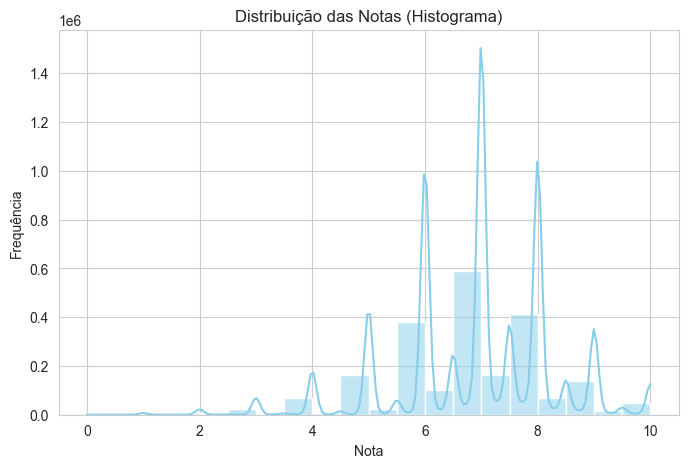

In [75]:
# Configuração visual
sns.set_style("whitegrid")

# --- 1. Estatísticas Descritivas das Notas ---
print("--- Estatísticas Descritivas das Notas ---")
all_ratings = ratings['Rating']
print(f"Média: {all_ratings.mean():.4f}")
print(f"Mediana: {all_ratings.median():.4f}")
print(f"Assimetria (Skewness): {skew(all_ratings):.4f}")
print(f"Curtose (Kurtosis): {kurtosis(all_ratings):.4f}")

# Gráfico 1: Histograma de Notas
plt.figure(figsize=(8, 5))
sns.histplot(all_ratings, bins=20, kde=True, color='skyblue')
plt.title('Distribuição das Notas (Histograma)')
plt.xlabel('Nota')
plt.ylabel('Frequência')
plt.savefig('hist_notas.png') # Salva para usar no Latex
plt.show()


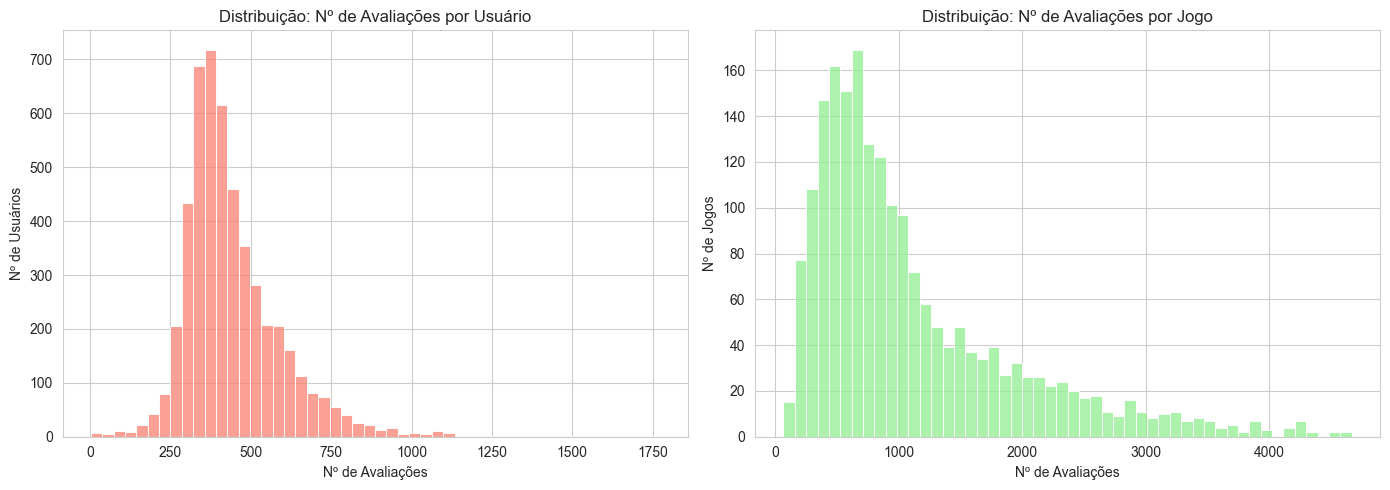

In [76]:

# --- 2. Distribuições de Cauda Longa ---
# Avaliações por Usuário
user_counts = ratings['Username'].value_counts()
# Avaliações por Jogo
game_counts = ratings['BGGId'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Usuários
sns.histplot(user_counts, bins=50, ax=axes[0], color='salmon')
axes[0].set_title('Distribuição: Nº de Avaliações por Usuário')
axes[0].set_xlabel('Nº de Avaliações')
axes[0].set_ylabel('Nº de Usuários')

# Plot Jogos
sns.histplot(game_counts, bins=50, ax=axes[1], color='lightgreen')
axes[1].set_title('Distribuição: Nº de Avaliações por Jogo')
axes[1].set_xlabel('Nº de Avaliações')
axes[1].set_ylabel('Nº de Jogos')

plt.tight_layout()
plt.savefig('distribuicao_cauda_longa.png')
plt.show()



Correlação (Pearson) entre Contagem e Média: 0.2781


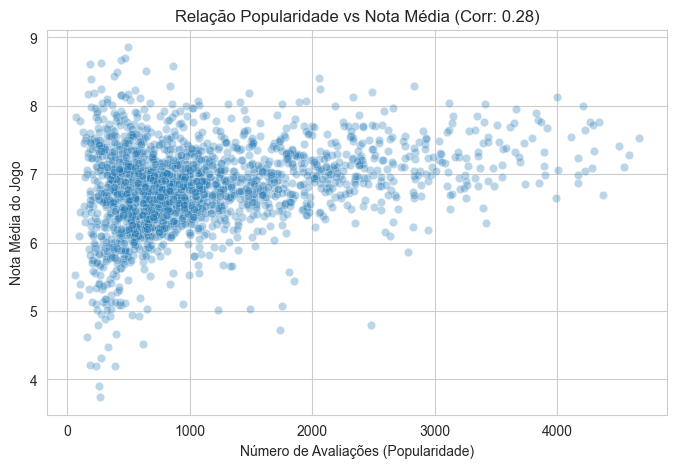

In [77]:

# --- 3. Correlação Popularidade vs Nota ---
game_stats = ratings.groupby('BGGId')['Rating'].agg(['count', 'mean'])
correlation = game_stats.corr(method='pearson') # Pode mudar para 'spearman'
print(f"\nCorrelação (Pearson) entre Contagem e Média: {correlation.loc['count', 'mean']:.4f}")

plt.figure(figsize=(8, 5))
sns.scatterplot(data=game_stats, x='count', y='mean', alpha=0.3)
plt.title(f'Relação Popularidade vs Nota Média (Corr: {correlation.loc["count", "mean"]:.2f})')
plt.xlabel('Número de Avaliações (Popularidade)')
plt.ylabel('Nota Média do Jogo')
plt.savefig('scatter_pop_nota.png')
plt.show()


Correlação (Spearman): 0.2501
Correlação (Pearson):  0.2781


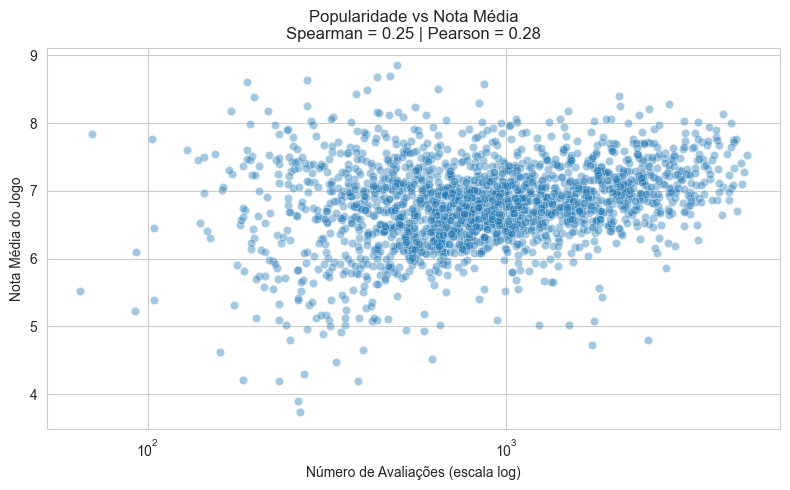

In [78]:

import seaborn as sns
import matplotlib.pyplot as plt

# --- 3. Correlação Popularidade vs Nota ---

game_stats = (
    ratings
    .groupby('BGGId')['Rating']
    .agg(['count', 'mean'])
)

# Filtra jogos com poucas avaliações (opcional, mas recomendado)
game_stats = game_stats[game_stats['count'] >= 5]

# Correlação de Spearman (mais adequada)
spearman_corr = game_stats.corr(method='spearman').loc['count', 'mean']
pearson_corr  = game_stats.corr(method='pearson').loc['count', 'mean']

print(f"Correlação (Spearman): {spearman_corr:.4f}")
print(f"Correlação (Pearson):  {pearson_corr:.4f}")

# Scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=game_stats,
    x='count',
    y='mean',
    alpha=0.4
)

plt.xscale('log')
plt.xlabel('Número de Avaliações (escala log)')
plt.ylabel('Nota Média do Jogo')
plt.title(
    f'Popularidade vs Nota Média\n'
    f'Spearman = {spearman_corr:.2f} | Pearson = {pearson_corr:.2f}'
)

plt.tight_layout()
plt.savefig('scatter_pop_nota.png')
plt.show()




--- Teste de Sensibilidade do Beta ---
Beta: 0.0 -> RMSE: 1.1141
Beta: 0.1 -> RMSE: 1.1093
Beta: 0.2 -> RMSE: 1.1072
Beta: 0.3 -> RMSE: 1.1078
Beta: 0.4 -> RMSE: 1.1112
Beta: 0.5 -> RMSE: 1.1173
Beta: 0.6 -> RMSE: 1.1261
Beta: 0.7 -> RMSE: 1.1375
Beta: 0.8 -> RMSE: 1.1514
Beta: 0.9 -> RMSE: 1.1678
Beta: 1.0 -> RMSE: 1.1865


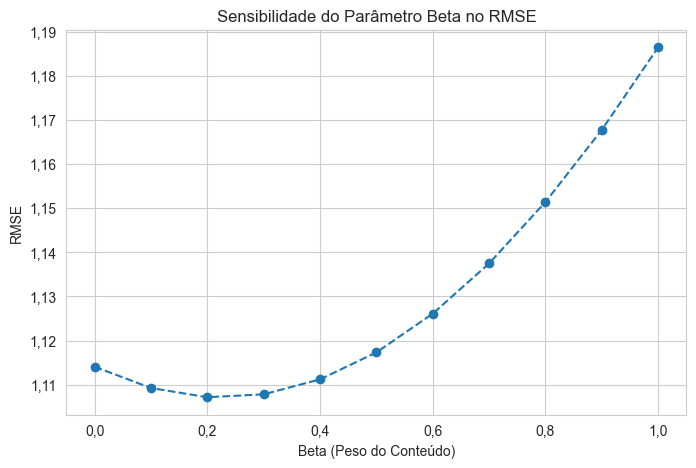

In [101]:
import locale
locale.setlocale(locale.LC_NUMERIC, 'pt_BR.UTF-8')

# --- 4. Sensibilidade do Beta (Modelo Híbrido) ---
# Executar isso APÓS ter calculado as matrizes e o baseline
beta_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
rmse_results = []

print("\n--- Teste de Sensibilidade do Beta ---")
for b in beta_values:
    # Recalcular previsões híbridas para cada beta
    y_pred_h = b * y_pred_bc + (1 - b) * y_pred_bl # Baseline puro nos NaNs do BC
    
    # Recalcula RMSE
    valid_mask = ~np.isnan(y_pred_h)
    rmse_val = np.sqrt(mean_squared_error(y_true[valid_mask], y_pred_h[valid_mask]))
    rmse_results.append(rmse_val)
    print(f"Beta: {b} -> RMSE: {rmse_val:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(beta_values, rmse_results, marker='o', linestyle='--')
plt.title('Sensibilidade do Parâmetro Beta no RMSE')
plt.xlabel('Beta (Peso do Conteúdo)')
plt.ylabel('RMSE')
plt.grid(True)
plt.savefig('sensibilidade_beta.png')
plt.show()


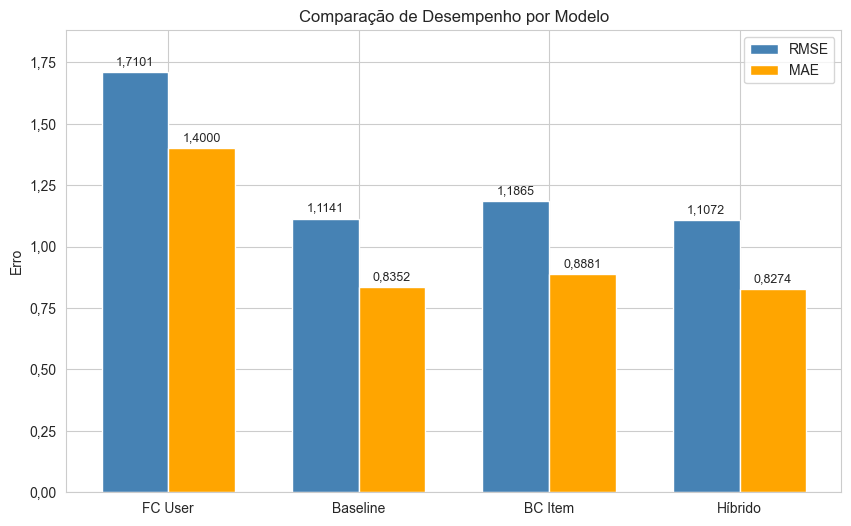

In [105]:
# --- 5. Comparação Visual dos Modelos (Barplot) ---
model_names = ['FC User', 'Baseline', 'BC Item', 'Híbrido']
rmse_vals = [rmse_fc, rmse_bl, rmse_bc, rmse_hybrid] # Valores que você obteve
mae_vals = [mae_fc, mae_bl, mae_bc, mae_hybrid]

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, rmse_vals, width, label='RMSE', color='steelblue')
rects2 = ax.bar(x + width/2, mae_vals, width, label='MAE', color='orange')

ax.set_ylabel('Erro')
ax.set_title('Comparação de Desempenho por Modelo')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

labels1 = [f"{v:.4f}".replace('.', ',') for v in rmse_vals]
labels2 = [f"{v:.4f}".replace('.', ',') for v in mae_vals]

ax.bar_label(rects1, labels=labels1, padding=3, fontsize=9)
ax.bar_label(rects2, labels=labels2, padding=3, fontsize=9)

# Ajusta o limite superior do eixo Y para dar espaço aos rótulos não ficarem cortados
ax.set_ylim(0, max(rmse_vals) * 1.1)


plt.savefig('comparacao_modelos.png')
plt.show()

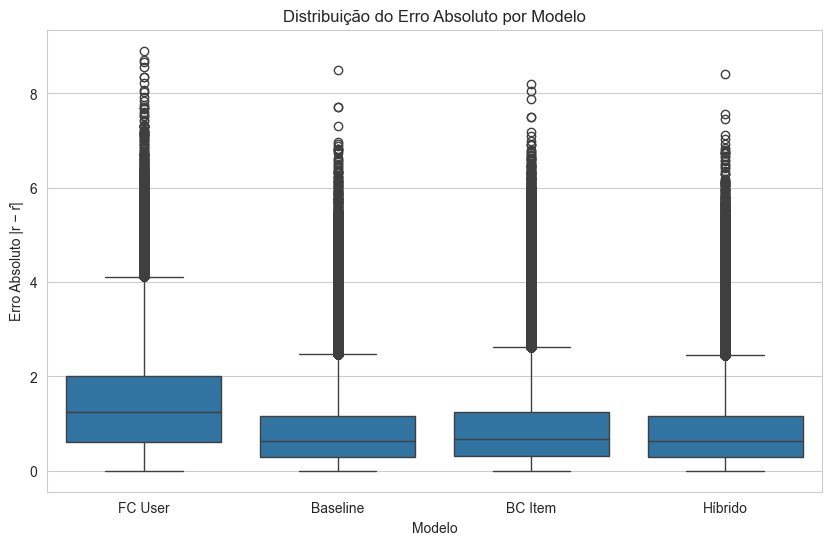

In [106]:
# Erros absolutos por instância
abs_err_fc = np.abs(y_true - y_pred_fc)
abs_err_bl = np.abs(y_true - y_pred_bl)
abs_err_bc = np.abs(y_true - y_pred_bc)
abs_err_hybrid = np.abs(y_true - y_pred_hybrid)


error_df = pd.DataFrame({
    'Erro Absoluto': np.concatenate([
        abs_err_fc,
        abs_err_bl,
        abs_err_bc,
        abs_err_hybrid
    ]),
    'Modelo': (
        ['FC User'] * len(abs_err_fc) +
        ['Baseline'] * len(abs_err_bl) +
        ['BC Item'] * len(abs_err_bc) +
        ['Híbrido'] * len(abs_err_hybrid)
    )
})


plt.figure(figsize=(10, 6))
sns.boxplot(
    data=error_df,
    x='Modelo',
    y='Erro Absoluto'
)

plt.title('Distribuição do Erro Absoluto por Modelo')
plt.ylabel('Erro Absoluto |r − r̂|')
plt.xlabel('Modelo')

plt.savefig('boxplot_erro_modelos.png')
plt.show()



## Teste do Melhor K para o medolo FC User

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Defina a lista de k que deseja testar
k_values = [10, 20, 30, 40, 50, 60, 80, 100]
preds_per_k = {k: [] for k in k_values}
y_true_list = []

print(f"Iniciando cálculo para k = {k_values}...")

# 2. Loop único sobre o test_df (Garante eficiência)
for index, row in test_df.iterrows():
    user = row['Username']
    item = row['BGGId']
    y_true_list.append(row['Rating'])
    
    # Lógica de fallback (exatamente como na sua função predict_cf_user_user)
    if user not in user_means.index or item not in R_train.columns:
        for k in k_values:
            preds_per_k[k].append(user_means.get(user, 0.0))
        continue
    
    # Componentes da predição
    mean_u = user_means[user]
    rated_by_v = R_train[item].dropna().index
    sim_u_v = sim_matrix.loc[user, rated_by_v].drop(user, errors='ignore')
    
    # Cálculo dos desvios ponderados (Sinal)
    weighted_deviations = sim_u_v * (R_train.loc[sim_u_v.index, item] - user_means.loc[sim_u_v.index])
    
    # ORDENAÇÃO ÚNICA: Ordenamos pela similaridade absoluta (nlargest logic)
    # Isso é feito uma vez por linha de teste
    sorted_neighbors = sim_u_v.abs().sort_values(ascending=False).index
    
    # 3. Cálculo para cada k (instantâneo)
    for k in k_values:
        top_k = sorted_neighbors[:k]
        sim_sum = sim_u_v.loc[top_k].abs().sum()
        
        if sim_sum == 0:
            preds_per_k[k].append(mean_u)
        else:
            num = weighted_deviations.loc[top_k].sum()
            preds_per_k[k].append(mean_u + (num / sim_sum))

# 4. Cálculo das métricas finais
rmse_results = []
mae_results = []
y_true_arr = np.array(y_true_list)

print("\n--- Resultados FC User-User ---")
for k in k_values:
    y_pred = np.array(preds_per_k[k])
    rmse, mae = calculate_accuracy_metrics(y_true_arr, y_pred)
    rmse_results.append(rmse)
    mae_results.append(mae)
    print(f"k={k} -> RMSE: {rmse:.4f} | MAE: {mae:.4f}")

Iniciando cálculo para k = [10, 20, 30, 40, 50, 60, 80, 100]...


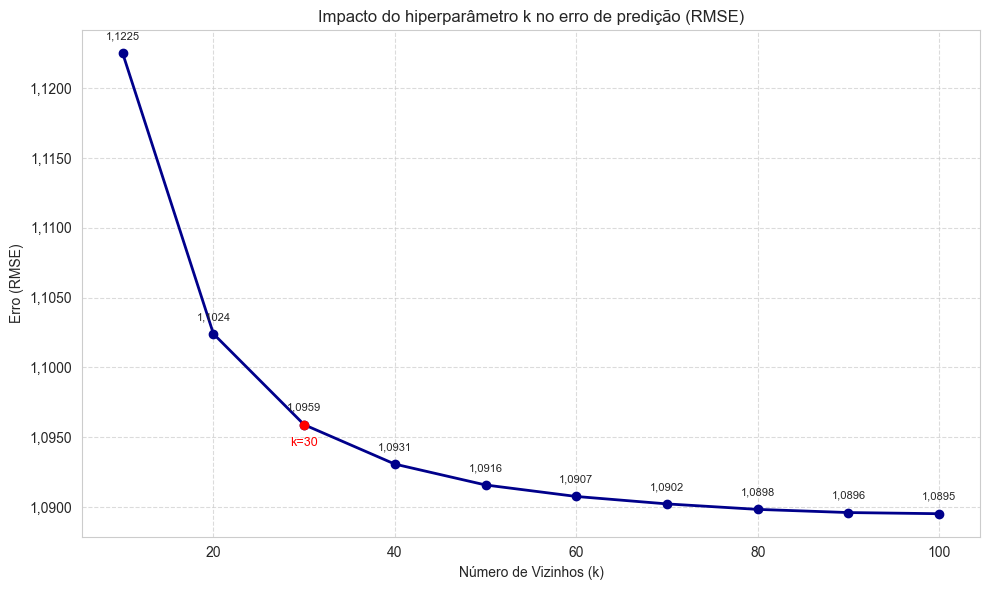

In [ ]:
import matplotlib.ticker as ticker

# Plotagem
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(k_values, rmse_results, marker='o', color='darkblue', label='RMSE')
ax1.plot(k_values, mae_results, marker='s', color='darkorange', label='MAE')

plt.title('Sensibilidade de k: RMSE vs MAE (FC User-User)')
plt.xlabel('Número de Vizinhos (k)')
plt.ylabel('Erro')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Formatação com vírgula
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.3f}'.replace('.', ',')))
plt.tight_layout()
plt.savefig('k_sweep_fc.png')
plt.show()

# Teste do Melhor $k$ para o Modelo BC item usando Jaccard

In [ ]:
# 1. Definições para BC
preds_bc_per_k = {k: [] for k in k_values}

print(f"\nIniciando cálculo para BC Item-Item...")

for index, row in test_df.iterrows():
    u, i = row['Username'], row['BGGId']
    
    # Fallback (usando média do usuário conforme seu notebook)
    if i not in sim_bc_jaccard.index:
        for k in k_values: preds_bc_per_k[k].append(user_means.get(u, 0.0))
        continue
        
    user_ratings = R_train.loc[u].dropna()
    if user_ratings.empty:
        for k in k_values: preds_bc_per_k[k].append(0.0)
        continue
    
    # Similaridade entre o item alvo e os itens avaliados pelo usuário
    sims_i_j = sim_bc_jaccard.loc[i, user_ratings.index]
    weighted_ratings = sims_i_j * user_ratings
    
    # Ordenação única por similaridade
    sorted_items = sims_i_j.abs().sort_values(ascending=False).index
    
    for k in k_values:
        top_k = sorted_items[:k]
        sim_sum = sims_i_j.loc[top_k].abs().sum()
        
        if sim_sum == 0:
            preds_bc_per_k[k].append(user_ratings.mean())
        else:
            preds_bc_per_k[k].append(weighted_ratings.loc[top_k].sum() / sim_sum)

# 2. Cálculo das métricas para BC
rmse_bc_results = []
mae_bc_results = []

print("\n--- Resultados BC Item-Item (Jaccard) ---")
for k in k_values:
    y_pred = np.array(preds_bc_per_k[k])
    rmse, mae = calculate_accuracy_metrics(y_true_arr, y_pred)
    rmse_bc_results.append(rmse)
    mae_bc_results.append(mae)
    print(f"k={k} -> RMSE: {rmse:.4f} | MAE: {mae:.4f}")

In [ ]:
import matplotlib.ticker as ticker

# Plotagem
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(k_values, rmse_bc_results, marker='o', color='darkgreen', label='RMSE')
ax1.plot(k_values, mae_bc_results, marker='s', color='olive', label='MAE')

plt.title('Sensibilidade de k: RMSE vs MAE (BC Item-Item Jaccard)')
plt.xlabel('Número de Vizinhos (k)')
plt.ylabel('Erro')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Formatação com vírgula
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.3f}'.replace('.', ',')))
plt.tight_layout()
plt.savefig('k_sweep_bc.png')
plt.show()